In [104]:
import torch
from torch import nn
from torchvision.datasets import MNIST
from torchvision import transforms
from tqdm import tqdm
from IPython.display import clear_output
from matplotlib import pyplot as plt
import numpy as np

from vision_lab.settings import DATA_DIR

In [143]:
def initialize_weights(model, mean=0.0, std=0.1):
    """
    Initialize the weights of a PyTorch model using normal distribution.

    Args:
        model: PyTorch model
        mean (float): Mean of the normal distribution
        std (float): Standard deviation of the normal distribution
    """
    for module in model.modules():
        if isinstance(module, (nn.Conv2d, nn.Linear)):
            # Initialize weights using normal distribution
            nn.init.normal_(module.weight.data, mean=mean, std=std)

            # Initialize biases with zeros
            if module.bias is not None:
                nn.init.zeros_(module.bias.data)

In [19]:
transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),  # range: [-1, 1]
])
dataset = MNIST(root=DATA_DIR, train=False, download=True, transform=transforms)
# Split dataset into train and validation
train_dataset = torch.utils.data.Subset(dataset, range(0, 9000))
val_dataset = torch.utils.data.Subset(dataset, range(9000, 10000))

In [35]:
model = torch.nn.Sequential(
    nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(64 * 28 * 28, 10),
)

In [36]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

In [37]:
epochs = 2
batch_size = 128
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [38]:
for epoch in range(epochs):
    model.train()
    loss_agg = 0.0
    accuracy = 0.0
    for batch_idx, (data, target) in tqdm(enumerate(train_dataloader), total=len(train_dataloader)):
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        accuracy += (output.argmax(dim=1) == target).float().mean().item()
        loss.backward()
        optimizer.step()
        loss_agg += loss.item()
    print(f"Epoch {epoch}, Loss: {loss_agg / len(train_dataloader)}, Accuracy: {accuracy / len(train_dataloader)}")

    model.eval()
    loss_agg = 0.0
    accuracy = 0.0
    for batch_idx, (data, target) in tqdm(enumerate(val_dataloader), total=len(val_dataloader)):
        output = model(data)
        loss = criterion(output, target)
        accuracy += (output.argmax(dim=1) == target).float().mean().item()
        loss_agg += loss.item()
    print(f"Validation Loss: {loss_agg / len(val_dataloader)}, Accuracy: {accuracy / len(val_dataloader)}")

100%|██████████| 71/71 [00:07<00:00, 10.05it/s]


Epoch 0, Loss: 0.5822857384320715, Accuracy: 0.832152288564494


100%|██████████| 8/8 [00:00<00:00, 33.34it/s]


Validation Loss: 0.2023123053368181, Accuracy: 0.9384014457464218


100%|██████████| 71/71 [00:06<00:00, 10.15it/s]


Epoch 1, Loss: 0.10066983177208565, Accuracy: 0.9684859153250573


100%|██████████| 8/8 [00:00<00:00, 32.75it/s]

Validation Loss: 0.12105398229323328, Accuracy: 0.9649188667535782


# Regression

In [145]:
device = "cuda:1" if torch.cuda.is_available() else "mps"
model = torch.nn.Sequential(
    nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(64 * 28 * 28, 1),
).to(device)
initialize_weights(model, mean=0.0, std=0.001)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

Epoch 199, Loss: 0.003173344367597666, Accuracy: 0.6604172554281023


100%|██████████| 2/2 [00:00<00:00, 35.92it/s]

Validation Loss: 0.011062631383538246, Accuracy: 0.45989689230918884


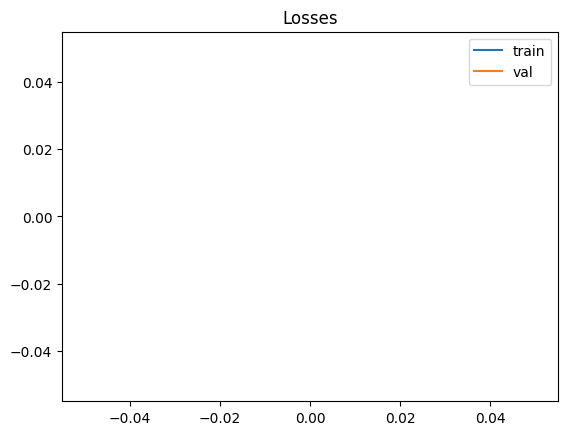

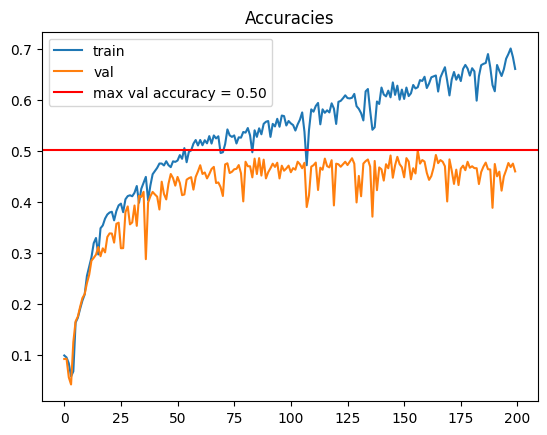

In [146]:
epochs = 200
batch_size = 512
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

losses_train = []
accuracies_train = []
losses_val = []
accuracies_val = []

for epoch in range(epochs):
    model.train()
    loss_agg = 0.0
    accuracy_1 = 0.0
    for batch_idx, (data, target) in tqdm(enumerate(train_dataloader), total=len(train_dataloader)):
        data = data.to(device)
        target = target.to(device)
        optimizer.zero_grad()
        output = model(data)  # (b, 1)
        loss = criterion(output, (target / 10.0).unsqueeze(1))
        accuracy_1 += ((output * 10).round() == target.unsqueeze(1)).float().mean().item()
        loss.backward()
        optimizer.step()
        loss_agg += loss.item()
    loss = loss_agg / len(train_dataloader)
    accuracy_1 = accuracy_1 / len(train_dataloader)
    losses_train.append(loss)
    accuracies_train.append(accuracy_1)
    clear_output()
    print(f"Epoch {epoch}, Loss: {loss}, Accuracy: {accuracy_1}")

    model.eval()
    loss_agg = 0.0
    accuracy_1 = 0.0
    for batch_idx, (data, target) in tqdm(enumerate(val_dataloader), total=len(val_dataloader)):
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        loss = criterion(output, (target / 10.0).unsqueeze(1))
        accuracy_1 += ((output * 10).round() == target.unsqueeze(1)).float().mean().item()
        loss_agg += loss.item()
    loss = loss_agg / len(val_dataloader)
    accuracy_1 = accuracy_1 / len(val_dataloader)
    losses_val.append(loss)
    accuracies_val.append(accuracy_1)
    print(f"Validation Loss: {loss}, Accuracy: {accuracy_1}")

    plt.title("Losses")
    plt.plot(losses_train[:-int(len(losses_train))], label='train')
    plt.plot(losses_val[:-int(len(losses_train))], label='val')
    # plt.ylim(min(losses_train + losses_val), max(np.median(losses_val), np.median(losses_train)) * 2)
    plt.legend()
    plt.show()

    plt.title("Accuracies")
    plt.plot(accuracies_train, label='train')
    plt.plot(accuracies_val, label='val')
    plt.axhline(max(accuracies_val), color='red', label=f'max val accuracy = {max(accuracies_val):.2f}')
    plt.legend()
    plt.show()

# Predicting Gaussian Distribution

In [147]:
device = "cuda:1" if torch.cuda.is_available() else "mps"
model = torch.nn.Sequential(
    nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(64 * 28 * 28, 2),
).to(device)
initialize_weights(model, mean=0.0, std=0.001)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.GaussianNLLLoss()

Epoch 199, Loss: -0.29763484829001957, Accuracy: 0.7076910899745094, Variance: 0.19863723307281872


100%|██████████| 2/2 [00:00<00:00, 32.23it/s]


Validation Loss: -0.27364693582057953, Accuracy: 0.4462730437517166


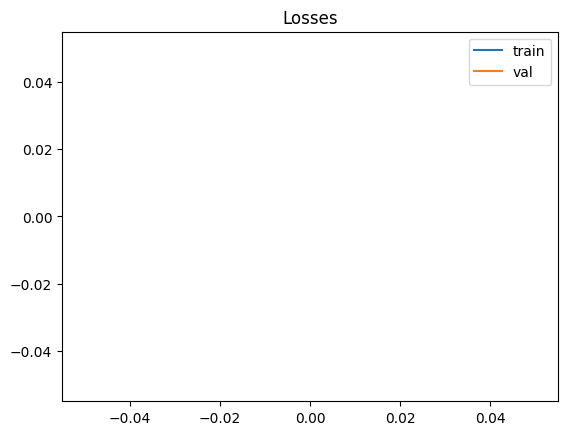

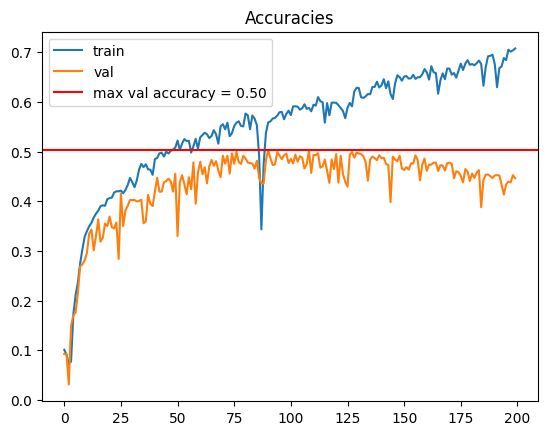

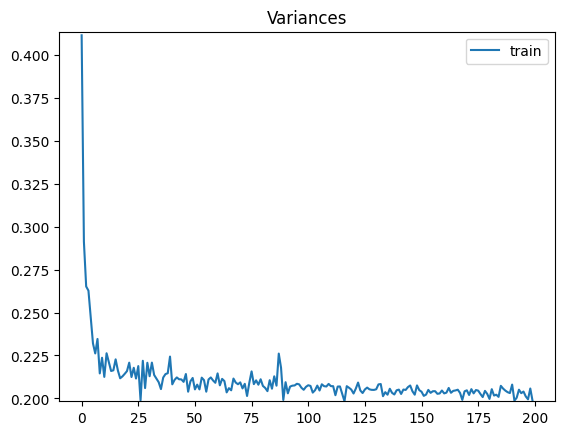

In [148]:
epochs = 200
batch_size = 512
auxillary_loss_lambda = 0.1
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

losses_train = []
accuracies_train = []
losses_val = []
accuracies_val = []
variances = []

running_mean_beta = 0.9
running_variance_mean = 0

for epoch in range(epochs):
    model.train()
    loss_agg = 0.0
    accuracy_1 = 0.0
    for batch_idx, (data, target) in tqdm(enumerate(train_dataloader), total=len(train_dataloader)):
        data = data.to(device)
        target = target.to(device)
        optimizer.zero_grad()
        output = model(data)  # (b, 2)
        mu = output[:, 0]
        log_var = output[:, 1]
        var = torch.exp(log_var)
        loss = criterion(mu, target / 10.0, var)
        auxillary = (1.0 / (var + 1e-6)).mean()
        loss += auxillary_loss_lambda * auxillary

        accuracy_1 += ((mu * 10).round() == target).float().mean().item()
        running_variance_mean = running_mean_beta * torch.mean(var).item() + (1 - running_mean_beta) * running_variance_mean
        loss.backward()
        optimizer.step()
        loss_agg += loss.item()
    loss = loss_agg / len(train_dataloader)
    accuracy_1 = accuracy_1 / len(train_dataloader)
    losses_train.append(loss)
    accuracies_train.append(accuracy_1)
    variances.append(running_variance_mean)
    clear_output()
    print(f"Epoch {epoch}, Loss: {loss}, Accuracy: {accuracy_1}, Variance: {running_variance_mean}")

    model.eval()
    loss_agg = 0.0
    accuracy_1 = 0.0
    for batch_idx, (data, target) in tqdm(enumerate(val_dataloader), total=len(val_dataloader)):
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        mu = output[:, 0]
        log_var = output[:, 1]
        var = torch.exp(log_var)
        loss = criterion(mu, target / 10.0, var)
        auxillary = (1.0 / (var + 1e-6)).mean()
        loss += auxillary_loss_lambda * auxillary
        accuracy_1 += ((mu * 10).round() == target).float().mean().item()
        loss_agg += loss.item()
    loss = loss_agg / len(val_dataloader)
    accuracy_1 = accuracy_1 / len(val_dataloader)
    losses_val.append(loss)
    accuracies_val.append(accuracy_1)
    print(f"Validation Loss: {loss}, Accuracy: {accuracy_1}")

    plt.title("Losses")
    plt.plot(losses_train[:-int(len(losses_train))], label='train')
    plt.plot(losses_val[:-int(len(losses_train))], label='val')
    # plt.ylim(min(losses_train + losses_val), max(np.median(losses_val), np.median(losses_train)) * 2)
    plt.legend()
    plt.show()

    plt.title("Accuracies")
    plt.plot(accuracies_train, label='train')
    plt.plot(accuracies_val, label='val')
    plt.axhline(max(accuracies_val), color='red', label=f'max val accuracy = {max(accuracies_val):.2f}')
    plt.legend()
    plt.show()

    plt.title("Variances")
    plt.plot(variances, label='train')
    plt.ylim(min(variances), np.median(variances) * 2)
    plt.legend()
    plt.show()